# California House Market Price Prediction

Author: Cayke Felipe dos Anjos

<img src="images/house.jpg" alt="Alt text" width="1200"/>

# Summary

In this project we analyze data from the California House Market competition from Kaggle (https://www.kaggle.com/c/california-house-prices/overview). 

For this problem, we are given a dataset with data containing a house's specifications (number of bedrooms, bathrooms, lot size, appliances, address...) and we build different regression models that predict its market price. If you are looking to buy a house, having a software that can show if a price is too high (bad deal) or too low (great deal) can save you some money or help you negotiate its value. If you are willing to sell your house, tho, knowing its price can help filter bad offers out.

The dataset is very disorganized at first. Several columns are actually redundant (like "Cooling" and "Cooling Features"), others are not filtered (number of bedrooms has several string entries) and a lot of missing data. The datasets are already divided into training and test set already, where the training set is used to fit models and tune their hyperparameters and the test set does not contain a target value. This is because, the test set must be submitted to the Kaggle Compeitition and the score is generated after. 

The main metric for this problem is the log RMSE: the Root Mean Squared Error between the log of the predicted value and the log of the true value. This is an important metric because of the different orders of magnitude we are dealing with. In this metric the error between predicting that a $\$100,000$ house actually costs $\$1,000,000$ is the same as predicting that a $\$1,000,000$ house costs $\$10,000,000$ which is one order of magnitude. However, because several models unfortunately still predict a negative price, we mainly use the normal RMSE to tune hyperparameters and choose our models. We still try to calculate log RMSE when possible and use it to choose our best model.

We first conduct an exploratory data analysis, clean the data and drop features that are redundant or not needed. We then build a pipeline that imputes missing data, one hot encodes left categorical data and standardized numerica data. Each model we test is coupled to this pipeline so we are able to have a pipeline ready for deployment in the end.

The best model is the XGBoost, with an log RMSE of 0.32, being closely followed by Random Forest (0.33) and GradientBoosting (0.35). We propose future steps and conclude our work.

# Business Problem

Buying a house is an important transition in a person's live. Besides being an important change between paying rent to live to own one yourself, houses can also be used an investiments or colaterals for banks. No matter if you are looking for a house to grow roots or to invest or if you are looking to sell your property, knowing its approximate market price can turn deals that seem good into bad or great ones.

Our client is a real state company. Being a real state company, they are always looking for the best deals for their clients who are trying to buy a house, meaning good houses being sold for less than what they should, or for a higher price for those are willing to sell. The real state market in the US is worth over 50 trillion dollars. It is one of the most important industries as everybody needs housing and their prices only go up with time.

This project aims to analyze data from the California House Market in order to be able to accurately predict the price of a house based on its features. Besides trying to answer which model is the best and how well does the algorithm do when compared to others we also try to answer:

* What are features that increase the house price?
* What are the cheapest and most expensive regions on average?
* What are the most important features used to predict the price?

# Exploratory Data Analysis and Data Cleaning

In [56]:
# We start by importing several libraries to our model. Notice that we also import myfunctions file with important 
# functions created to clean the data.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
import numpy as np
from myfunctions import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, MaxAbsScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

%matplotlib inline
import warnings,os
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [57]:
df = pd.read_csv('data/train.csv')
df.rename(columns={'Appliances included':'Appliances','Laundry features':'Laundry'},inplace=True)
print_full_cols(df)

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Region,Elementary School,Elementary School Score,Elementary School Distance,Middle School,Middle School Score,Middle School Distance,High School,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances,Laundry,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,"Ground Floor Bedroom, Master Bedroom on Ground...",0.0,NaN,1.0,0.0,0.0,Los Altos,Santa Rita Elementary School,7.0,0.4,NaN,NaN,NaN,Los Altos High School,8.0,1.3,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,3,2.0,2.0,872.0,1.0,1.0,Los Angeles,Raymond Avenue Elementary School,3.0,0.8,John Muir Middle School,2.0,1.1,Augustus F. Hawkins High A Critical Design And...,2.0,1.3,NaN,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",NaN,Inside,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,2,3.0,1.0,1152.0,0.0,0.0,Strawberry,NaN,NaN,NaN,NaN,NaN,NaN,Long Barn High School,NaN,10.1,NaN,Forced air,NaN,NaN,NaN,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,5,3.0,3.0,2612.0,0.0,0.0,Culver City,Farragut Elementary School,9.0,0.2,Culver City Middle School,7.0,0.2,Culver City High School,8.0,0.2,"Wood, Tile",Central,Central Air,Dishwasher,"Stackable, Upper Level","Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Creston,Santa Margarita Elementary School,6.0,8.5,Atascadero Middle School,5.0,10.2,Atascadero High School,6.0,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47434,47434,2409 Florence Blvd,159000.0,"2409 Florence Blvd, Blythe, CA 92225 is a sing...",SingleFamily,1965.0,Central,Central Air,"Carport, Covered",20908.8,3,2.0,2.0,1432.0,2.0,2.0,Blythe,Margaret White Elementary School,3.0,2.4,NaN,NaN,NaN,Palo Verde High School,3.0,1.8,"Carpet, Tile",Forced air,Central,"Dishwasher, Range / Oven",NaN,"Carport, Covered",125049.0,1298.0,2020-09-04,155000.0,NaN,NaN,Blythe,92225,CA
47435,47435,1085 Tasman Dr SPACE 818,255000.0,"LOOK AT THIS PRICE $30k PRICE REDUCTION, USE T...",MobileManufactured,1999.0,"Central Forced Air, Gas",Central AC,Carport,NaN,3,2.0,2.0,1560.0,0.0,0.0,Sunnyvale,George Mayne Elementary School,5.0,2.4,Marian A. Peterson Middle School,6.0,3.5,Adrian Wilcox High School,7.0,2.5,NaN,"Forced air, Gas",Central,NaN,Hookups Only,Carport,68924.0,721.0,2020-07-23,295900.0,NaN,NaN,Sunnyvale,94089,CA
47436,47436,1338 N Orange Grove Ave,2300000.0,Beautifully restored historic Coloni

In [58]:
df.describe()

,Id,Sold Price,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Zip
count,47439.000000,4.743900e+04,46394.000000,3.325800e+04,43974.000000,39574.000000,4.491300e+04,46523.000000,46522.000000,42543.000000,42697.000000,30734.000000,30735.000000,42220.000000,42438.000000,4.378700e+04,43129.000000,4.743900e+04,2.967300e+04,47439.000000
mean,23719.000000,1.296050e+06,1956.634888,2.353383e+05,2.355642,2.094961,5.774587e+03,1.567117,1.491746,5.720824,1.152411,5.317206,1.691593,6.134344,2.410366,7.863118e+05,9956.843817,1.315890e+06,8.078537e+05,93279.178587
std,13694.604047,1.694452e+06,145.802456,1.192507e+07,1.188805,0.963320,8.324363e+05,9.011608,8.964319,2.103350,2.332367,2.002768,2.462879,1.984711,3.596120,1.157796e+06,13884.254976,2.628695e+06,1.177903e+06,2263.459104
min,0.000000,1.005000e+05,0.000000,0.000000e+00,0.000000,1.000000,1.000000e+00,-15.000000,-15.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,85611.000000
25%,11859.500000,5.650000e+05,1946.000000,4.991000e+03,2.000000,2.000000,1.187000e+03,0.000000,0.000000,4.000000,0.300000,4.000000,0.600000,5.000000,0.800000,2.549615e+05,3467.000000,5.745000e+05,3.350000e+05,90220.000000
50%,23719.000000,9.600000e+05,1967.000000,6.502000e+03,2.000000,2.000000,1.566000e+03,1.000000,1.000000,6.000000,0.500000,5.000000,1.000000,6.000000,1.300000,5.475240e+05,7129.000000,9.490000e+05,5.980000e+05,94114.000000
75%,35578.500000,1.525000e+06,1989.000000,1.045400e+04,3.000000,2.000000,2.142000e+03,2.000000,2.000000,7.000000,1.000000,7.000000,1.800000,8.000000,2.400000,9.371625e+05,12010.000000,1.498844e+06,9.500000e+05,95073.000000
max,47438.000000,9.000000e+07,9999.000000,1.897474e+09,24.000000,17.000000,1.764164e+08,1000.000000,1000.000000,10.000000,57.200000,9.000000,57.200000,10.000000,73.900000,4.590000e+07,552485.000000,4.025320e+08,9.000000e+07,96155.000000


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47439 entries, 0 to 47438
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           47439 non-null  int64  
 1   Address                      47439 non-null  object 
 2   Sold Price                   47439 non-null  float64
 3   Summary                      47085 non-null  object 
 4   Type                         47439 non-null  object 
 5   Year built                   46394 non-null  float64
 6   Heating                      40587 non-null  object 
 7   Cooling                      26745 non-null  object 
 8   Parking                      46065 non-null  object 
 9   Lot                          33258 non-null  float64
 10  Bedrooms                     44567 non-null  object 
 11  Bathrooms                    43974 non-null  float64
 12  Full bathrooms               39574 non-null  float64
 13  Total interior l

In [60]:
df.isna().sum()

Id                                 0
Address                            0
Sold Price                         0
Summary                          354
Type                               0
Year built                      1045
Heating                         6852
Cooling                        20694
Parking                         1374
Lot                            14181
Bedrooms                        2872
Bathrooms                       3465
Full bathrooms                  7865
Total interior livable area     2526
Total spaces                     916
Garage spaces                    917
Region                             2
Elementary School               4742
Elementary School Score         4896
Elementary School Distance      4742
Middle School                  16704
Middle School Score            16705
Middle School Distance         16704
High School                     5000
High School Score               5219
High School Distance            5001
Flooring                       11569
H

After exploring the data we notice a few things:
* there is a lot of missing data in most of the columns;
* there are a lot of outlier regarding the sold price (75% is $\$1.525$M but max is $\$90$M);
* there are a lot of different columns with categorical data, including features that SHOULD NOT ("Bedrooms")

# We need to impute or clean the data in each of those features

We have developed several functions to clean the data as needed. Because of the amount of data, some generalization had to be done in a few cases.

In [61]:
type_fix(df)
heating_fix(df)
cooling_fix(df)
parking_fix(df)
bedroom_fix(df)
region_fix(df)
top_floorings= top_of_the_feat(df,'Flooring')
df = top_of_the_feat_encoder(df,'Flooring',top_floorings)
top_appliances = top_of_the_feat(df,'Appliances')
df = top_of_the_feat_encoder(df,'Appliances', top_appliances)
top_laundry = top_of_the_feat(df,'Laundry')
df = top_of_the_feat_encoder(df,'Laundry', top_laundry)
listedon_fix(df)
state_fix(df)
delete_columns(df)

In [62]:
print_full_cols(df)

,Sold Price,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Region,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold Price,State,Flooring_tile,Flooring_carpet,Flooring_wood,Flooring_vinyl,Flooring_laminate,Flooring_hardwood,Flooring_linoleum,Flooring_stone,Flooring_concrete,Flooring_marble,Flooring_slate,Appliances_dishwasher,Appliances_refrigerator,Appliances_disposal,Appliances_microwave,Appliances_washer,Appliances_dryer,Appliances_gasrange,Appliances_rangehood,Appliances_gasoven,Appliances_gaswaterheater,Appliances_oven,Appliances_gascooktop,Appliances_range,Appliances_doubleoven,Appliances_built,Appliances_electricrange,Appliances_free,Appliances_standingrange,Appliances_selfcleaningoven,Appliances_waterheater,Appliances_tanklesswaterheater,Appliances_electricoven,Appliances_ventedexhaustfan,Appliances_in,Appliances_freezer,Appliances_barbecue,Appliances_icemaker,Appliances_trashcompactor,Appliances_electriccooktop,Appliances_convectionoven,Appliances_inrange,Appliances_energystarqualifiedappliances,Appliances_waterlinetorefrigerator,Appliances_6burnerstove,Appliances_garbagedisposal,Appliances_waterpurifier,Appliances_propanerange,Appliances_gascooking,Appliances_plumbedforicemaker,Appliances_electricwaterheater,Appliances_watersoftener,Laundry_washer,Laundry_inside,Laundry_dryer,Laundry_laundryroom,Laundry_ingarage,Laundry_electricdryerhookup,Laundry_washerhookup,Laundry_electricityhookup(220v),Laundry_sink,Laundry_inutilityroom,Laundry_gasdryerhookup,Laundry_gashookup,Laundry_tub,Laundry_laundrycloset,Laundry_electricityhookup(110v),Laundry_gas,Laundry_stackable,Laundry_inkitchen,Laundry_upperfloor,Laundry_upperlevel,Laundry_cabinets,Laundry_outside
0,3825000.0,SingleFamily,1969.0,Gas,Central AC,Covered Garage,1.0,3.0,0.0,NaN,1.0,0.0,0.0,Los Altos,7.0,0.4,NaN,NaN,8.0,1.3,886486.0,12580.0,433,4198000.0,NaN,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,505000.0,SingleFamily,1926.0,Other,Wall/Window Unit,Detached Garage,4047.0,3.0,2.0,2.0,872.0,1.0,1.0,Los Angeles,3.0,0.8,2.0,1.1,2.0,1.3,505000.0,6253.0,441,525000.0,328000.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140000.0,SingleFamily,1958.0,Forced Air,NaN,None,9147.0,2.0,3.0,1.0,1152.0,0.0,0.0,Other,NaN,NaN,NaN,NaN,NaN,10.1,49627.0,468.0,493,180000.0,NaN,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1775000.0,SingleFamily,1947.0,Central,Central AC,Detached Garage,NaN,5.0,3.0,3.0,2612.0,0.0,0.0,Culver City,9.0,0.2,7.0,0.2,8.0,0.2,1775000.0,20787.0,433,1895000.0,1500000.0,1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1175000.0,VacantLand,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,6.0,8.5,5.0,10.2,6.0,10.6,NaN,NaN,572,1595000.0,900000.0,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,

# Building Pipelines

We add the next preprocessing steps into a pipeline.

In [63]:
X = df.drop('Sold Price',axis=1)
y = df['Sold Price']

In [64]:
nominal_pipeline = Pipeline([
    ('onehotimputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehotenc', OneHotEncoder(sparse_output = False, drop = 'first', handle_unknown = 'ignore'))])

nominal_noohe_pipeline = Pipeline([
    ('onehotimputer', SimpleImputer(strategy = 'most_frequent'))
])
numeric_pipeline = Pipeline([('numimputer', SimpleImputer()), ('numnorm', StandardScaler())])

In [65]:
nominal_columns = ['Type','Heating','Cooling','Parking','Region']
noohe_columns = X.columns[24:]
numeric_columns = [column for column in X.columns if (column not in nominal_columns) and (column not in noohe_columns)]
numeric_columns

['Year built',
 'Lot',
 'Bedrooms',
 'Bathrooms',
 'Full bathrooms',
 'Total interior livable area',
 'Total spaces',
 'Garage spaces',
 'Elementary School Score',
 'Elementary School Distance',
 'Middle School Score',
 'Middle School Distance',
 'High School Score',
 'High School Distance',
 'Tax assessed value',
 'Annual tax amount',
 'Listed On',
 'Listed Price',
 'Last Sold Price']

In [66]:
ct = ColumnTransformer([
    ('nominalpipe',nominal_pipeline,nominal_columns),
    ('noohepipe', nominal_noohe_pipeline,noohe_columns),
    ('numericpipe', numeric_pipeline, numeric_columns)
])

In [67]:
ct

ColumnTransformer(transformers=[('nominalpipe',
                                 Pipeline(steps=[('onehotimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotenc',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Type', 'Heating', 'Cooling', 'Parking',
                                  'Region']),
                                ('noohepipe',
                                 Pipeline(steps=[('onehotimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Ind...
                                                 ('numnorm',
                                                  StandardScaler())]),
                                 ['Year built', 'Lot', 'Bedrooms', 'Bathrooms',
                                  'Full bathrooms',
                                  'Total interior livable area', 'Total spaces',
                                  'Garage spaces', 'Elementary School Score',
                                  'Elementary School Distance',
                                  'Middle School Score',
                                  'Middle School Distance', 'High School Score',
                                  'High School Distance', 'Tax assessed value',
                                  'Annual tax amount', 'Listed On',
                                  'Listed Price', 'Last Sold Price'])])

# Scoring
For the scoring we use a special RMSE funtion where we subtract the logarithm of the observed price from the logarithm of the predicted price on the following form.

logRMSE=$\sqrt{\frac{1}{N}\sum(\log y_\text{true}-\log y_\text{pred})^2)}$

In [68]:
def logrmse(y, y_pred):
    from numpy import log
    n = len(y)
    log1 = log((y_pred))
    log2 = log(y)
    difference = log1 - log2
    return ((1/n)*sum(np.power(difference,2)))**0.5
    
logrmse_scorer = make_scorer(logrmse, greater_is_better=False)

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally for different magnitude orders. However, some models have a problem with this metric (meaning its predicting y_pred<=0) so we use the negative RMSE as a score.

# Train and test sets

A test set has been given for the final score but we need to use part of the train set to test our model.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# Baseline model - Linear Regression

In [70]:
lr = LinearRegression()

In [71]:
lr_pipeline = Pipeline([('preprocess', ct),
                        ('model',lr)
    
])
lr_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                  ['Year built', 'Lot',
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression())])

In [72]:
lr_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False]}

In [73]:
gs_lr = GridSearchCV(estimator=lr_pipeline, 
                       param_grid=lr_param_grid, scoring = 'neg_root_mean_squared_error')
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [74]:
gs_lr.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('onehotim...
                                                                          'Middle '
                                                                          'School '
                                                                          'Distance',
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [75]:
gs_lr.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [76]:
best_estimator_lr = gs_lr.best_estimator_

In [77]:
best_estimator_lr.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [78]:
y_pred_lr = best_estimator_lr.predict(X_test)

(-1000000.0, 15000000.0)

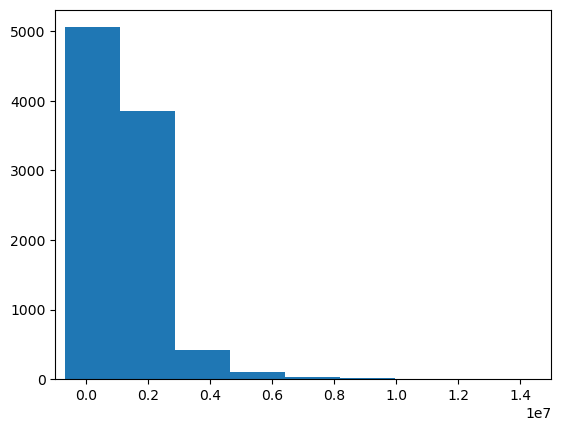

In [79]:
plt.hist(y_pred_lr,bins=2000)
plt.xlim(-1000000,15000000)

Text(0, 0.5, 'Count')

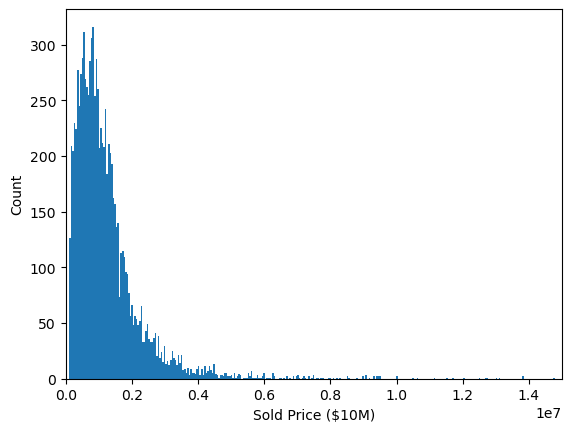

In [80]:
plt.hist(y_test,bins=1000)
plt.xlim(0,15000000)
plt.xlabel('Sold Price ($10M)')
plt.ylabel('Count')

In [81]:
logrmse_lr,rmse_lr = logrmse(y_test,y_pred_lr), mean_squared_error(y_test,y_pred_lr,squared=False)
logrmse_lr,rmse_lr

(nan, 36429774.84452176)

As we can see this model fails to come up with only positive answers. This might be caused by the presence of outliers in our dataset.

# 1st Model - Linear Regression with 2 estimators

<Axes: >

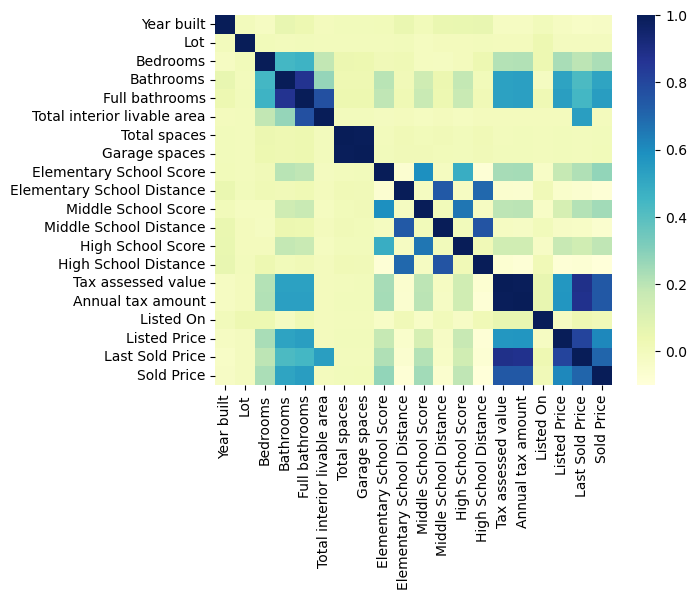

In [84]:
corr = df[numeric_columns+['Sold Price']].corr()
sns.heatmap(corr,cmap="YlGnBu")

In [85]:
corr_columns = [column for column in df.columns if (column not in nominal_columns)]
df[corr_columns]
corr = df[corr_columns].corr()
corr['Sold Price'].sort_values(ascending=False).head(15)

Sold Price                 1.000000
Annual tax amount          0.746221
Tax assessed value         0.743233
Last Sold Price            0.706779
Listed Price               0.612651
Full bathrooms             0.544245
Bathrooms                  0.516208
Elementary School Score    0.275555
Middle School Score        0.244285
Bedrooms                   0.230111
High School Score          0.191616
State                      0.057527
Appliances_dishwasher      0.032614
Appliances_refrigerator    0.031672
Appliances_microwave       0.029996
Name: Sold Price, dtype: float64

<Axes: >

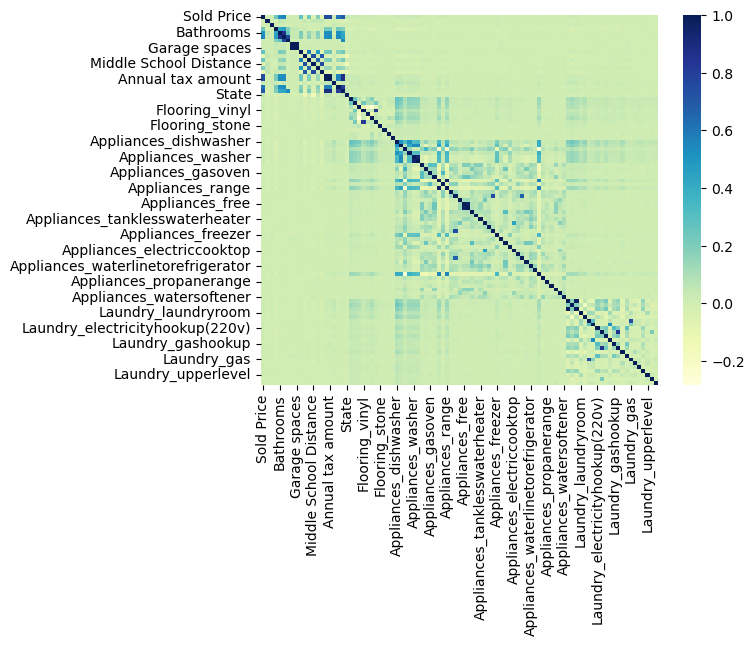

In [86]:
sns.heatmap(corr,cmap="YlGnBu")

We plan to divide the dataset into 2: one for expensive houses (over 4M), one for cheaper houses (under 4M). For that we use two features that do not have missing features all together: Tax assessed value and Listed Price. We first try using Tax assessed value and if the value is nan we use Listed Price.

In [87]:
len(df[(df['Tax assessed value'].isna()) & (df['Listed Price'].isna())])

0

(0.0, 10000000.0)

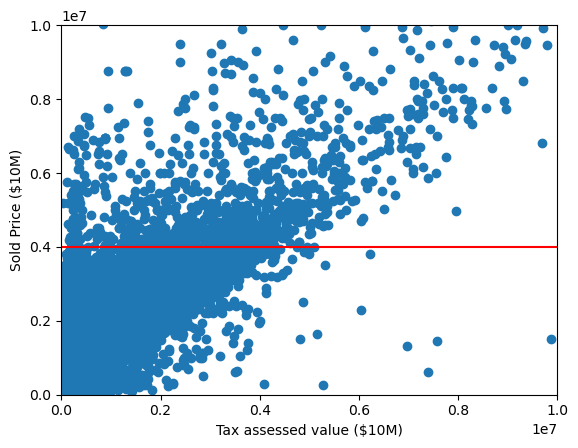

In [88]:
plt.scatter(df['Tax assessed value'],df['Sold Price'])
plt.hlines(y=4000000,xmin=0,xmax=10000000,colors='r')
plt.xlabel('Tax assessed value ($10M)')
plt.ylabel('Sold Price ($10M)')
plt.xlim(0,10000000)
plt.ylim(0,10000000)

(0.0, 10000000.0)

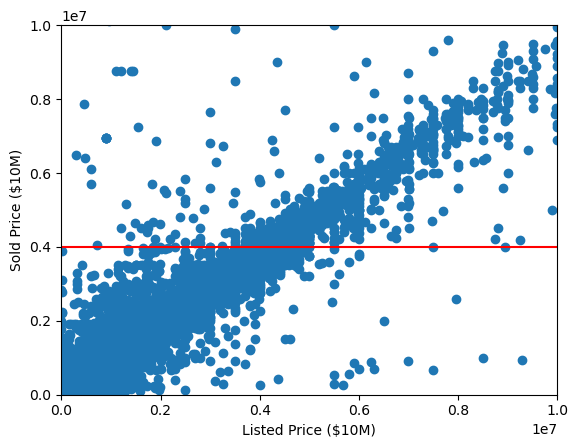

In [89]:
plt.scatter(df['Listed Price'],df['Sold Price'])
plt.hlines(y=4000000,xmin=0,xmax=10000000,colors='r')
plt.xlabel('Listed Price ($10M)')
plt.ylabel('Sold Price ($10M)')
plt.xlim(0,10000000)
plt.ylim(0,10000000)

Judging by both graphs we can use the the threshold of both $\$5M$, meaning this threshold maximizes the number of outliers in the outlier dataset and minimizes the number of cheaper houses in there.

In [90]:
X_train_expensive = X_train[(((X_train['Tax assessed value'].isna()) & (X_train['Listed Price']>5*10**6))) | 
(X_train['Tax assessed value']>5*10**6)]

y_train_expensive = y_train.loc[X_train_expensive.index]

X_train_cheap = X_train[(((X_train['Tax assessed value'].isna()) & (X_train['Listed Price']<=5*10**6))) | 
(X_train['Tax assessed value']<=5*10**6)]

y_train_cheap = y_train.loc[X_train_cheap.index]

# len(X_train_lr_expensive), len(y_train_lr_expensive), len(X_train_lr_cheap), len(y_train_lr_cheap)

In [91]:
X_test_expensive = X_test[(((X_test['Tax assessed value'].isna()) & (X_test['Listed Price']>5*10**6))) | 
(X_test['Tax assessed value']>5*10**6)]

y_test_expensive = y_test.loc[X_test_expensive.index]

X_test_cheap = X_test[(((X_test['Tax assessed value'].isna()) & (X_test['Listed Price']<=5*10**6))) | 
(X_test['Tax assessed value']<=5*10**6)]

y_test_cheap = y_test.loc[X_test_cheap.index]


In [92]:
ratio_expensive = len(X_train_expensive)/len(X_train)
ratio_cheap = 1-ratio_expensive

ratio_expensive,ratio_cheap

(0.009433216516033833, 0.9905667834839662)

In [93]:
lr_expensive = LinearRegression()
lr_cheap = LinearRegression()

In [94]:
lr_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',lr_expensive)])

lr_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',lr_cheap)])

In [95]:
lr_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False]}

In [96]:
gs_lr_expensive = GridSearchCV(estimator=lr_exp_pipeline, 
                       param_grid=lr_param_grid, scoring = 'neg_root_mean_squared_error',cv=2)

gs_lr_cheap = GridSearchCV(estimator=lr_cheap_pipeline, 
                       param_grid=lr_param_grid, scoring = 'neg_root_mean_squared_error',cv=2)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [97]:
gs_lr_expensive.fit(X_train_expensive,y_train_expensive)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'Middle '
                                                                          'School '
                                                                          'Distance',
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [98]:
gs_lr_cheap.fit(X_train_cheap,y_train_cheap)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'Middle '
                                                                          'School '
                                                                          'Distance',
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [99]:
best_estimator_lr_cheap = gs_lr_cheap.best_estimator_
best_estimator_lr_exp = gs_lr_expensive.best_estimator_
gs_lr_cheap.best_params_, gs_lr_expensive.best_params_

({'model__fit_intercept': False,
  'preprocess__numericpipe__numimputer__strategy': 'mean'},
 {'model__fit_intercept': False,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

In [100]:
best_estimator_lr_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_lr_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', LinearRegression(fit_intercept=False))])

In [101]:
y_pred_lr_exp = best_estimator_lr_exp.predict(X_test_expensive)
y_pred_lr_cheap = best_estimator_lr_cheap.predict(X_test_cheap)

In [102]:
logrmse_lr_cheap,rmse_lr_cheap = logrmse(y_test_cheap,y_pred_lr_cheap), mean_squared_error(y_test_cheap,y_pred_lr_cheap,squared=False)
logrmse_lr_cheap,rmse_lr_cheap

(nan, 27552232.958691236)

In [103]:
logrmse_lr_exp,rmse_lr_exp = logrmse(y_test_expensive,y_pred_lr_exp), mean_squared_error(y_test_expensive,y_pred_lr_exp,squared=False)
logrmse_lr_exp,rmse_lr_exp

(nan, 5087087.006984416)

In [104]:
(ratio_cheap*rmse_lr_cheap**2+ratio_expensive*rmse_lr_exp**2)**0.5

27426422.70658933

Just by putting outliers in a different estimator, we lowered our RMSE by about 25%

# 2nd Model - Elastic Net

For this model we will keep using the divided data but we introduce regularization

In [ ]:
en_cheap = ElasticNet(max_iter=100000,random_state=19)
en_exp = ElasticNet(max_iter=100000,random_state=19)

In [ ]:
en_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',en_exp)])

en_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',en_cheap)])

In [ ]:
# en_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
#                  'model__fit_intercept':[True,False],
#                  'model__alpha':[0.1,0.5,1,5,10],
#                  'model__l1_ratio':[0.1,0.25,0.5,0.75,0.9]}

#We already ruan the grid and these are the best parameters
en_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False],
                 'model__alpha':[1,5],
                 'model__l1_ratio':[0.25,0.75]}

In [ ]:
gs_en_expensive = GridSearchCV(estimator=en_exp_pipeline, 
                               param_grid=en_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2)

gs_en_cheap = GridSearchCV(estimator=en_cheap_pipeline, 
                           param_grid=en_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=10)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [54]:
gs_en_expensive.fit(X_train_expensive,y_train_expensive)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        ElasticNet(max_iter=100000,
                                                   random_state=19))]),
             param_grid={'model__alpha': [1, 5],
                         'model__fit_intercept': [True, False],
                         'model__l1_ratio': [0.25, 0.75],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [55]:
gs_en_cheap.fit(X_train_cheap,y_train_cheap)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        ElasticNet(max_iter=100000,
                                                   random_state=19))]),
             param_grid={'model__alpha': [1, 5],
                         'model__fit_intercept': [True, False],
                         'model__l1_ratio': [0.25, 0.75],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error')

In [56]:
best_estimator_en_cheap = gs_en_cheap.best_estimator_
best_estimator_en_exp = gs_en_expensive.best_estimator_
gs_en_cheap.best_params_, gs_en_expensive.best_params_

({'model__alpha': 5,
  'model__fit_intercept': True,
  'model__l1_ratio': 0.25,
  'preprocess__numericpipe__numimputer__strategy': 'mean'},
 {'model__alpha': 1,
  'model__fit_intercept': True,
  'model__l1_ratio': 0.75,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

Best Elastic Net model has hyperparameters:

-For expensive houses - alpha=1, l1_ratio=0.75;

-For cheap houses - alpha=5, l1_ratio=0.25.

In [57]:
best_estimator_en_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_en_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model',
                 ElasticNet(alpha=1, l1_ratio=0.75, max_iter=100000,
                            random_state=19))])

In [58]:
y_pred_en_exp = best_estimator_en_exp.predict(X_test_expensive)
y_pred_en_cheap = best_estimator_en_cheap.predict(X_test_cheap)

In [59]:
logrmse_en_cheap,rmse_en_cheap = logrmse(y_test_cheap,y_pred_en_cheap), mean_squared_error(y_test_cheap,y_pred_en_cheap,squared=False)
logrmse_en_cheap,rmse_en_cheap

(nan, 14701118.446155887)

In [60]:
logrmse_en_exp,rmse_en_exp = logrmse(y_test_expensive,y_pred_en_exp), mean_squared_error(y_test_expensive,y_pred_en_exp,squared=False)
logrmse_en_exp,rmse_en_exp

(0.33896595190279166, 3959709.8115433133)

In [61]:
(ratio_cheap*rmse_en_cheap**2+ratio_expensive*rmse_en_exp**2)**0.5

14636668.195383811

# 3rd Model - Lasso Regressor

In [62]:
lasso_cheap = Lasso(max_iter=100000,random_state=19)
lasso_exp = Lasso(max_iter=100000,random_state=19)

In [63]:
lasso_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',lasso_exp)])

lasso_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',lasso_cheap)])

In [64]:
# lasso_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
#                  'model__fit_intercept':[True,False],
#                  'model__alpha':[0.01,0.05,0.1,0.5,1,5,10,50,100]}

#We ran this before and get these numbers:
lasso_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False],
                 'model__alpha':[100]}

In [65]:
gs_lasso_expensive = GridSearchCV(estimator=lasso_exp_pipeline, 
                               param_grid=lasso_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2,verbose=3)

gs_lasso_cheap = GridSearchCV(estimator=lasso_cheap_pipeline, 
                           param_grid=lasso_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=10,verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [66]:
gs_lasso_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-8201277.729 total time=   1.2s
[CV 2/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-7269589.233 total time=   0.6s
[CV 1/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7924563.589 total time=   1.3s
[CV 2/2] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-7203428.396 total time=   0.6s
[CV 1/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-8257645.467 total time=   1.1s
[CV 2/2] END model__alpha=100, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-7465498.206 total time=   0.7s
[CV 1/2] END model__alpha=100, model__fit

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Lasso(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [67]:
gs_lasso_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-770266.296 total time=   2.8s
[CV 2/10] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-630544.624 total time=   5.6s
[CV 3/10] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-523572.691 total time=   5.3s
[CV 4/10] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-1834550.927 total time=   4.2s
[CV 5/10] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-868796.166 total time=   5.7s
[CV 6/10] END model__alpha=100, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-983693.701 total time=   5.3s
[CV 7/10] END model__alpha=100, model__fit_i

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Lasso(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [68]:
best_estimator_lasso_cheap = gs_lasso_cheap.best_estimator_
best_estimator_lasso_exp = gs_lasso_expensive.best_estimator_
gs_lasso_cheap.best_params_, gs_lasso_expensive.best_params_

({'model__alpha': 100,
  'model__fit_intercept': False,
  'preprocess__numericpipe__numimputer__strategy': 'mean'},
 {'model__alpha': 100,
  'model__fit_intercept': True,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

Best Lasso model has hyperparameters:

-For expensive houses - alpha=100,  fit_intercept=False;

-For cheap houses - alpha=100.

In [69]:
best_estimator_lasso_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_lasso_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', Lasso(alpha=100, max_iter=100000, random_state=19))])

In [70]:
y_pred_lasso_exp = best_estimator_lasso_exp.predict(X_test_expensive)
y_pred_lasso_cheap = best_estimator_lasso_cheap.predict(X_test_cheap)

In [71]:
logrmse_lasso_cheap,rmse_lasso_cheap = logrmse(y_test_cheap,y_pred_lasso_cheap), mean_squared_error(y_test_cheap,y_pred_lasso_cheap,squared=False)
logrmse_lasso_cheap,rmse_lasso_cheap

(nan, 27471660.680527855)

In [72]:
logrmse_lasso_exp,rmse_lasso_exp = logrmse(y_test_expensive,y_pred_lasso_exp), mean_squared_error(y_test_expensive,y_pred_lasso_exp,squared=False)
logrmse_lasso_exp,rmse_lasso_exp

(nan, 5038534.43426243)

In [73]:
(ratio_cheap*rmse_lasso_cheap**2+ratio_expensive*rmse_lasso_exp**2)**0.5

27346159.614071336

# 4th Model - Ridge Regressor

In [74]:
ridge_cheap = Ridge(max_iter=100000,random_state=19)
ridge_exp = Ridge(max_iter=100000,random_state=19)

In [75]:
ridge_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',ridge_exp)])

ridge_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',ridge_cheap)])

In [76]:
# ridge_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
#                  'model__fit_intercept':[True,False],
#                  'model__alpha':[0.01,0.05,0.1,0.5,1,5,10,50,100]}

#We already ran this and can delete other alphas that were not chosen
ridge_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__fit_intercept':[True,False],
                 'model__alpha':[50,100]}

In [77]:
gs_ridge_expensive = GridSearchCV(estimator=ridge_exp_pipeline, 
                               param_grid=ridge_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=3)

gs_ridge_cheap = GridSearchCV(estimator=ridge_cheap_pipeline, 
                           param_grid=ridge_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=10,verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [78]:
gs_ridge_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-3601511.435 total time=   0.1s
[CV 2/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-4408328.676 total time=   0.1s
[CV 1/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-3606051.676 total time=   0.1s
[CV 2/2] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=median;, score=-4391489.461 total time=   0.1s
[CV 1/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-3993957.626 total time=   0.1s
[CV 2/2] END model__alpha=50, model__fit_intercept=False, preprocess__numericpipe__numimputer__strategy=mean;, score=-4667779.222 total time=   0.1s
[CV 1/2] END model__alpha=50, model__fit_inter

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Ridge(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [50, 100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [79]:
gs_ridge_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-771851.659 total time=   0.4s
[CV 2/10] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-630417.997 total time=   0.4s
[CV 3/10] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-521974.929 total time=   0.4s
[CV 4/10] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-1835070.819 total time=   0.4s
[CV 5/10] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-871230.551 total time=   0.4s
[CV 6/10] END model__alpha=50, model__fit_intercept=True, preprocess__numericpipe__numimputer__strategy=mean;, score=-987436.887 total time=   0.4s
[CV 7/10] END model__alpha=50, model__fit_intercep

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        Ridge(max_iter=100000,
                                              random_state=19))]),
             param_grid={'model__alpha': [50, 100],
                         'model__fit_intercept': [True, False],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [80]:
best_estimator_ridge_cheap = gs_ridge_cheap.best_estimator_
best_estimator_ridge_exp = gs_ridge_expensive.best_estimator_
gs_ridge_cheap.best_params_, gs_ridge_expensive.best_params_

({'model__alpha': 100,
  'model__fit_intercept': False,
  'preprocess__numericpipe__numimputer__strategy': 'mean'},
 {'model__alpha': 50,
  'model__fit_intercept': True,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

Best Ridge model has hyperparameters:

-For expensive houses - model__alpha': 50,
  'model__fit_intercept': True,
  'preprocess__numericpipe__numimputer__strategy': 'median';

-For cheap houses - 'model__alpha': 100,
  'model__fit_intercept': False,
  'preprocess__numericpipe__numimputer__strategy': 'mean'.

In [81]:
best_estimator_ridge_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_ridge_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Bedrooms', 'Bathrooms',
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model', Ridge(alpha=50, max_iter=100000, random_state=19))])

In [82]:
y_pred_ridge_exp = best_estimator_ridge_exp.predict(X_test_expensive)
y_pred_ridge_cheap = best_estimator_ridge_cheap.predict(X_test_cheap)

In [83]:
logrmse_ridge_cheap,rmse_ridge_cheap = logrmse(y_test_cheap,y_pred_ridge_cheap), mean_squared_error(y_test_cheap,y_pred_ridge_cheap,squared=False)
logrmse_ridge_cheap,rmse_ridge_cheap

(nan, 27477921.965850372)

In [84]:
logrmse_ridge_exp,rmse_ridge_exp = logrmse(y_test_expensive,y_pred_ridge_exp), mean_squared_error(y_test_expensive,y_pred_ridge_exp,squared=False)
logrmse_ridge_exp,rmse_ridge_exp

(0.33576076640560826, 3801175.5459188353)

In [85]:
(ratio_cheap*rmse_ridge_cheap**2+ratio_expensive*rmse_ridge_exp**2)**0.5

27350504.11945781

# 5th Model - Decision Tree Regressor

In [86]:
dtr_cheap = DecisionTreeRegressor(random_state=19)
dtr_exp = DecisionTreeRegressor(random_state=19)

In [87]:
dtr_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',dtr_exp)])

dtr_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',dtr_cheap)])

In [88]:
# dtr_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
#                  'model__max_depth':[10,15,20,25,30]}

# We already ran this grid, these are the best hyperparameters
dtr_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
                 'model__max_depth':[20,25]}

In [89]:
gs_dtr_expensive = GridSearchCV(estimator=dtr_exp_pipeline, 
                               param_grid=dtr_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2,verbose=3)

gs_dtr_cheap = GridSearchCV(estimator=dtr_cheap_pipeline, 
                           param_grid=dtr_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=10, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [90]:
gs_dtr_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-4130610.414 total time=   0.1s
[CV 2/2] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-4028782.143 total time=   0.1s
[CV 1/2] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=median;, score=-4171489.681 total time=   0.0s
[CV 2/2] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=median;, score=-4652175.342 total time=   0.0s
[CV 1/2] END model__max_depth=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4130610.414 total time=   0.0s
[CV 2/2] END model__max_depth=25, preprocess__numericpipe__numimputer__strategy=mean;, score=-4028782.143 total time=   0.0s
[CV 1/2] END model__max_depth=25, preprocess__numericpipe__numimputer__strategy=median;, score=-4171489.681 total time=   0.0s
[CV 2/2] END model__max_depth=25, preprocess__numericpipe__n

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=19))]),
             param_grid={'model__max_depth': [20, 25],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [91]:
gs_dtr_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-723433.433 total time=   1.4s
[CV 2/10] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-849233.990 total time=   1.3s
[CV 3/10] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-397014.476 total time=   1.3s
[CV 4/10] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-1865766.502 total time=   1.3s
[CV 5/10] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-506743.999 total time=   1.3s
[CV 6/10] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-679991.355 total time=   1.3s
[CV 7/10] END model__max_depth=20, preprocess__numericpipe__numimputer__strategy=mean;, score=-436591.180 total time=   1.3s
[CV 8/10] END model__max_depth=20, preprocess__numericpipe__num

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                          'High '
                                                                          'School '
                                                                          'Score',
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=19))]),
             param_grid={'model__max_depth': [20, 25],
                         'preprocess__numericpipe__numimputer__strategy': ['mean',
                                                                           'median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [92]:
best_estimator_dtr_cheap = gs_dtr_cheap.best_estimator_
best_estimator_dtr_exp = gs_dtr_expensive.best_estimator_
gs_dtr_cheap.best_params_, gs_dtr_expensive.best_params_

({'model__max_depth': 25,
  'preprocess__numericpipe__numimputer__strategy': 'median'},
 {'model__max_depth': 20,
  'preprocess__numericpipe__numimputer__strategy': 'mean'})

Best Decisoon Tree model has hyperparameters:

-For expensive houses - max_depth=15, n_estimators=50;

-For cheap houses - max_depth=25, n_estimators=25.

In [93]:
best_estimator_dtr_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_dtr_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Full bathrooms',
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=20, random_state=19))])

In [94]:
y_pred_dtr_exp = best_estimator_dtr_exp.predict(X_test_expensive)
y_pred_dtr_cheap = best_estimator_dtr_cheap.predict(X_test_cheap)

In [95]:
logrmse_dtr_cheap,rmse_dtr_cheap = logrmse(y_test_cheap,y_pred_dtr_cheap), mean_squared_error(y_test_cheap,y_pred_dtr_cheap,squared=False)
logrmse_dtr_cheap,rmse_dtr_cheap

(0.2600934574886969, 981345.5843234885)

In [96]:
logrmse_dtr_exp,rmse_dtr_exp = logrmse(y_test_expensive,y_pred_dtr_exp), mean_squared_error(y_test_expensive,y_pred_dtr_exp,squared=False)
logrmse_dtr_exp,rmse_dtr_exp

(0.30407737620144554, 4000056.164470394)

In [97]:
(ratio_cheap*rmse_dtr_cheap**2 + ratio_expensive*rmse_dtr_exp**2)**0.5

1051137.6226639561

In [98]:
(ratio_cheap*logrmse_dtr_cheap**2 + ratio_expensive*logrmse_dtr_exp**2)**0.5

0.26054306103261005

# 6th Model - Random Forest

In [99]:
rf_cheap = RandomForestRegressor(random_state=19)
rf_exp = RandomForestRegressor(random_state=19)

In [100]:
rf_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',rf_exp)])

rf_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',rf_cheap)])

In [101]:
# rf_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
#                  'model__n_estimators':[25,50,100,150],
#                  'model__max_depth':[10,15,20,25]}
# We already ran this but kernel restarted
rf_param_grid = {'preprocess__numericpipe__numimputer__strategy':["median"],
                 'model__n_estimators':[25,50],
                 'model__max_depth':[15,25]}

In [102]:
gs_rf_expensive = GridSearchCV(estimator=rf_exp_pipeline, 
                               param_grid=rf_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2,verbose=3)

gs_rf_cheap = GridSearchCV(estimator=rf_cheap_pipeline, 
                           param_grid=rf_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=10, verbose=3)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [103]:
gs_rf_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3432006.165 total time=   0.1s
[CV 2/2] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3570349.929 total time=   0.1s
[CV 1/2] END model__max_depth=15, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3353790.669 total time=   0.2s
[CV 2/2] END model__max_depth=15, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3542014.495 total time=   0.2s
[CV 1/2] END model__max_depth=25, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3504405.898 total time=   0.1s
[CV 2/2] END model__max_depth=25, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-3579406.283 total time=   0.1s
[CV 1/2] END model__max_depth=25, m

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=19))]),
             param_grid={'model__max_depth': [15, 25],
                         'model__n_estimators': [25, 50],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [104]:
gs_rf_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-705836.772 total time=  12.6s
[CV 2/10] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-346629.068 total time=  12.4s
[CV 3/10] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-283538.689 total time=  12.1s
[CV 4/10] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-1724787.612 total time=  12.3s
[CV 5/10] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-528132.510 total time=  12.2s
[CV 6/10] END model__max_depth=15, model__n_estimators=25, preprocess__numericpipe__numimputer__strategy=median;, score=-589419.223 total time=  12.3s
[CV 7/10] END model__max_depth=1

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                          'High '
                                                                          'School '
                                                                          'Distance',
                                                                          'Tax '
                                                                          'assessed '
                                                                          'value',
                                                                          'Annual '
                                                                          'tax '
                                                                          'amount',
                                                                          'Listed '
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=19))]),
             param_grid={'model__max_depth': [15, 25],
                         'model__n_estimators': [25, 50],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=3)

In [105]:
best_estimator_rf_cheap = gs_rf_cheap.best_estimator_
best_estimator_rf_exp = gs_rf_expensive.best_estimator_
gs_rf_cheap.best_params_, gs_rf_expensive.best_params_

({'model__max_depth': 25,
  'model__n_estimators': 25,
  'preprocess__numericpipe__numimputer__strategy': 'median'},
 {'model__max_depth': 15,
  'model__n_estimators': 50,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

Best Random Forest model has hyperparameters:

-For expensive houses - 'model__max_depth': 15,
  'model__n_estimators': 50,
  'preprocess__numericpipe__numimputer__strategy': 'median';

-For cheap houses - 'model__max_depth': 25,
  'model__n_estimators': 25,
  'preprocess__numericpipe__numimputer__strategy': 'median'

In [106]:
best_estimator_rf_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_rf_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Total interior livable '
                                                   'area',
                                                   'Total spaces',
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model',
                 RandomForestRegressor(max_depth=15, n_estimators=50,
                                       random_state=19))])

In [107]:
y_pred_rf_exp = best_estimator_rf_exp.predict(X_test_expensive)
y_pred_rf_cheap = best_estimator_rf_cheap.predict(X_test_cheap)

In [108]:
logrmse_rf_cheap,rmse_rf_cheap = logrmse(y_test_cheap,y_pred_rf_cheap), mean_squared_error(y_test_cheap,y_pred_rf_cheap,squared=False)
logrmse_rf_cheap,rmse_rf_cheap

(0.21217702050106016, 701452.3041837491)

In [109]:
logrmse_rf_exp,rmse_rf_exp = logrmse(y_test_expensive,y_pred_rf_exp), mean_squared_error(y_test_expensive,y_pred_rf_exp,squared=False)
logrmse_rf_exp,rmse_rf_exp

(0.26225370797301417, 3151143.1738909464)

In [110]:
(ratio_cheap*rmse_rf_cheap**2 + ratio_expensive*rmse_rf_exp**2)**0.5

762274.8194626453

In [111]:
(ratio_cheap*logrmse_rf_cheap**2 + ratio_expensive*logrmse_rf_exp**2)**0.5

0.2127044936657286

# 7th Model - Gradient Boosting

In [112]:
grad_cheap = GradientBoostingRegressor(n_iter_no_change=10,validation_fraction=0.2 ,random_state=19)
grad_exp = GradientBoostingRegressor(n_iter_no_change=10,validation_fraction=0.2 ,random_state=19)

In [113]:
grad_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',grad_exp)])

grad_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',grad_cheap)])

In [114]:
# grad_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
#                  'model__n_estimators':[20,30,40,50,75,100],
#                  'model__learning_rate':[0.1,1,10],
#                  'model__max_depth':[2,3,4,5,10]}

#Grad ran before and these are the best hyperparameters
grad_param_grid = {'preprocess__numericpipe__numimputer__strategy':[ "median"],
                 'model__n_estimators':[50,100],
                 'model__learning_rate':[0.1],
                 'model__max_depth':[2,4]}

In [115]:
gs_grad_expensive = GridSearchCV(estimator=grad_exp_pipeline, 
                               param_grid=grad_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2, verbose=4)

gs_grad_cheap = GridSearchCV(estimator=grad_cheap_pipeline, 
                           param_grid=grad_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=10,verbose=4)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [116]:
gs_grad_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3089734.727 total time=   0.2s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3483436.615 total time=   0.1s
[CV 1/2] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3089734.727 total time=   0.1s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=100, preprocess__numericpipe__numimputer__strategy=median;, score=-3483436.615 total time=   0.1s
[CV 1/2] END model__learning_rate=0.1, model__max_depth=4, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-3346835.044 total time=   0.1s
[CV 2/2] END model__learning_rate=0.1, model__max_depth=4, 

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        GradientBoostingRegressor(n_iter_no_change=10,
                                                                  random_state=19,
                                                                  validation_fraction=0.2))]),
             param_grid={'model__learning_rate': [0.1],
                         'model__max_depth': [2, 4],
                         'model__n_estimators': [50, 100],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [117]:
gs_grad_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV 1/10] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-658090.266 total time=   8.5s
[CV 2/10] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-363263.233 total time=   8.5s
[CV 3/10] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-258127.927 total time=   8.2s
[CV 4/10] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-1728332.183 total time=   8.1s
[CV 5/10] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=50, preprocess__numericpipe__numimputer__strategy=median;, score=-666140.546 total time=   8.7s
[CV 6/10] END model__learning_rate=0.1, model__max_depth=2

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                          'On',
                                                                          'Listed '
                                                                          'Price',
                                                                          'Last '
                                                                          'Sold '
                                                                          'Price'])])),
                                       ('model',
                                        GradientBoostingRegressor(n_iter_no_change=10,
                                                                  random_state=19,
                                                                  validation_fraction=0.2))]),
             param_grid={'model__learning_rate': [0.1],
                         'model__max_depth': [2, 4],
                         'model__n_estimators': [50, 100],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [118]:
best_estimator_grad_cheap = gs_grad_cheap.best_estimator_
best_estimator_grad_exp = gs_grad_expensive.best_estimator_
gs_grad_cheap.best_params_, gs_grad_expensive.best_params_

({'model__learning_rate': 0.1,
  'model__max_depth': 4,
  'model__n_estimators': 100,
  'preprocess__numericpipe__numimputer__strategy': 'median'},
 {'model__learning_rate': 0.1,
  'model__max_depth': 2,
  'model__n_estimators': 50,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

Best GradBoost model has hyperparameters:

-For expensive houses - model__learning_rate': 0.1,
  'model__max_depth': 2,
  'model__n_estimators': 50,
  'preprocess__numericpipe__numimputer__strategy': 'median'

-For cheap houses - 'model__learning_rate': 0.1,
  'model__max_depth': 4,
  'model__n_estimators': 100,
  'preprocess__numericpipe__numimputer__strategy': 'median'.

In [119]:
best_estimator_grad_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_grad_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                   'Garage spaces',
                                                   'Elementary School Score',
                                                   'Elementary School Distance',
                                                   'Middle School Score',
                                                   'Middle School Distance',
                                                   'High School Score',
                                                   'High School Distance',
                                                   'Tax assessed value',
                                                   'Annual tax amount',
                                                   'Listed On', 'Listed Price',
                                                   'Last Sold Price'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=2, n_estimators=50,
                                           n_iter_no_change=10, random_state=19,
                                           validation_fraction=0.2))])

In [120]:
y_pred_grad_exp = best_estimator_grad_exp.predict(X_test_expensive)
y_pred_grad_cheap = best_estimator_grad_cheap.predict(X_test_cheap)

In [121]:
logrmse_grad_cheap,rmse_grad_cheap = logrmse(y_test_cheap,y_pred_grad_cheap), mean_squared_error(y_test_cheap,y_pred_grad_cheap,squared=False)
logrmse_grad_cheap,rmse_grad_cheap

(0.20947701071617772, 529419.5275817534)

In [122]:
logrmse_grad_exp,rmse_grad_exp = logrmse(y_test_expensive,y_pred_grad_exp), mean_squared_error(y_test_expensive,y_pred_grad_exp,squared=False)
logrmse_grad_exp,rmse_grad_exp

(0.283521418829858, 3172856.973120391)

In [123]:
(ratio_cheap*rmse_grad_cheap**2 + ratio_expensive*rmse_grad_exp**2)**0.5

610414.1536897897

In [124]:
(ratio_cheap*logrmse_grad_cheap**2 + ratio_expensive*logrmse_grad_exp**2)**0.5

0.2102973277288467

# 8th Model - XGBoost

In [107]:
xgb_cheap = xgb.XGBRegressor(random_state=19)
xgb_exp = xgb.XGBRegressor(random_state=19)

In [108]:
xgb_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',xgb_exp)])

xgb_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',xgb_cheap)])

In [120]:
# xgb_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean", "median"],
#                   # 'model__booster':['gbtree','gblinear','dart'],
#                   'model__colsample_bylevel':[0.5,1],
#                   'model__learning_rate':[0.1],
#                   'model__max_depth':[10,20,30,40],
#                   'model__n_estimators':[50,100,150,200],
#                   'model__subsample':[0.5,1]}

#We already ran this and got the results
xgb_param_grid = {'preprocess__numericpipe__numimputer__strategy':["mean"],
                  # 'model__booster':['gbtree','gblinear','dart'],
                  'model__colsample_bylevel':[0.5],
                  'model__learning_rate':[0.1],
                  'model__max_depth':[10,40],
                  'model__n_estimators':[50,150],
                  'model__subsample':[0.5,1]}


In [121]:
gs_xgb_expensive = GridSearchCV(estimator=xgb_exp_pipeline, 
                               param_grid=xgb_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2,verbose=4)

gs_xgb_cheap = GridSearchCV(estimator=xgb_cheap_pipeline, 
                           param_grid=xgb_param_grid2, scoring = 'neg_root_mean_squared_error',
                           cv=10,verbose=4)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [122]:
gs_xgb_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=50, model__subsample=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-3154153.199 total time=   0.1s
[CV 2/2] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=50, model__subsample=0.5, preprocess__numericpipe__numimputer__strategy=mean;, score=-3448627.524 total time=   0.1s
[CV 1/2] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=50, model__subsample=1, preprocess__numericpipe__numimputer__strategy=mean;, score=-3571782.139 total time=   0.1s
[CV 2/2] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=10, model__n_estimators=50, model__subsample=1, preprocess__numericpipe__numimputer__strategy=mean;, score=-3352880.773 total time=   0.1s
[CV 1/2] END model__colsample_byleve

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=19, ...))]),
             param_grid={'model__colsample_bylevel': [0.5],
                         'model__learning_rate': [0.1],
                         'model__max_depth': [10, 40],
                         'model__n_estimators': [50, 150],
                         'model__subsample': [0.5, 1],
                         'preprocess__numericpipe__numimputer__strategy': ['mean']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [123]:
gs_xgb_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=40, model__n_estimators=50, model__subsample=1, preprocess__numericpipe__numimputer__strategy=mean;, score=-466313.016 total time=  11.0s
[CV 2/10] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=40, model__n_estimators=50, model__subsample=1, preprocess__numericpipe__numimputer__strategy=mean;, score=-383853.350 total time=  11.3s
[CV 3/10] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=40, model__n_estimators=50, model__subsample=1, preprocess__numericpipe__numimputer__strategy=mean;, score=-278909.804 total time=  11.9s
[CV 4/10] END model__colsample_bylevel=0.5, model__learning_rate=0.1, model__max_depth=40, model__n_estimators=50, model__subsample=1, preprocess__numericpipe__numimputer__strategy=mean;, score=-1670872.706 total time=  11.5s
[CV 5/10] END model__colsample_bylevel

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=19, ...))]),
             param_grid={'model__colsample_bylevel': [0.5],
                         'model__learning_rate': [0.1],
                         'model__max_depth': [40], 'model__n_estimators': [50],
                         'model__subsample': [1],
                         'preprocess__numericpipe__numimputer__strategy': ['mean']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [124]:
best_estimator_xgb_cheap = gs_xgb_cheap.best_estimator_
best_estimator_xgb_exp = gs_xgb_expensive.best_estimator_
gs_xgb_cheap.best_params_, gs_xgb_expensive.best_params_

({'model__colsample_bylevel': 0.5,
  'model__learning_rate': 0.1,
  'model__max_depth': 40,
  'model__n_estimators': 50,
  'model__subsample': 1,
  'preprocess__numericpipe__numimputer__strategy': 'mean'},
 {'model__colsample_bylevel': 0.5,
  'model__learning_rate': 0.1,
  'model__max_depth': 10,
  'model__n_estimators': 150,
  'model__subsample': 0.5,
  'preprocess__numericpipe__numimputer__strategy': 'mean'})

Best XGBoost model has hyperparameters:

-For expensive houses - 'model__colsample_bylevel': 0.5,
  'model__learning_rate': 0.1,
  'model__max_depth': 10,
  'model__n_estimators': 150,
  'model__subsample': 0.5,
  'preprocess__numericpipe__numimputer__strategy': 'mean'

-For cheap houses - 'model__colsample_bylevel': 0.5,
  'model__learning_rate': 0.1,
  'model__max_depth': 40,
  'model__n_estimators': 50,
  'model__subsample': 1,
  'preprocess__numericpipe__numimputer__strategy': 'mean'.

In [125]:
best_estimator_xgb_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_xgb_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=150, n_jobs=None,
                              num_parallel_tree=None, random_state=19, ...))])

In [126]:
y_pred_xgb_exp = best_estimator_xgb_exp.predict(X_test_expensive)
y_pred_xgb_cheap = best_estimator_xgb_cheap.predict(X_test_cheap)

In [127]:
logrmse_xgb_cheap,rmse_xgb_cheap = logrmse(y_test_cheap,y_pred_xgb_cheap), mean_squared_error(y_test_cheap,y_pred_xgb_cheap,squared=False)
logrmse_xgb_cheap,rmse_xgb_cheap

(0.1998266730329679, 433009.89373868937)

In [128]:
logrmse_xgb_exp,rmse_xgb_exp = logrmse(y_test_expensive,y_pred_xgb_exp), mean_squared_error(y_test_expensive,y_pred_xgb_exp,squared=False)
logrmse_xgb_exp,rmse_xgb_exp

(0.2565971614839081, 3106683.135505969)

In [129]:
(ratio_cheap*rmse_xgb_cheap**2 + ratio_expensive*rmse_xgb_exp**2)**0.5

526092.543612864

In [130]:
(ratio_cheap*logrmse_xgb_cheap**2 + ratio_expensive*logrmse_xgb_exp**2)**0.5

0.20043733968459565

Results are as following:

|Model|RMSE (in $\$M$)|Log RMSE|
|---|---|---|
|Linear Regression|36.42|-|
|2 Linear Regressions|27.042 |-|
|Elastic Net|14.63 | -|
|Lasso|27.34 | -|
|Ridge|27.35 |- |
|Decision Tree Regressor|1.05 |0.26 |
|Random Forests|0.76 |0.21 |
|Gradient Boosting|0.61 |0.21 |
|XGBoost|0.53 |0.20 |

# Last Model - Stacking + Decision Tree

In [155]:
stackdt_cheap = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(max_depth=25, n_estimators=25,
                                        random_state=19)),
        ('gradboost', GradientBoostingRegressor(max_depth=4, n_estimators=100,n_iter_no_change=10, #Check n_estimators
                                            random_state=19,
                                            validation_fraction=0.2,learning_rate=0.1)),
        ('xgboost',xgb.XGBRegressor(random_state=19,colsample_bylevel= 0.5, learning_rate= 0.1,
                                    max_depth= 40, n_estimators= 50, subsample= 1))
    ],
    final_estimator=DecisionTreeRegressor(random_state=19)
)

stackdt_exp = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(max_depth=15, n_estimators=50,
                                        random_state=19)),
        ('gradboost', GradientBoostingRegressor(max_depth=2, n_estimators=50,n_iter_no_change=10,
                                            random_state=19,
                                            validation_fraction=0.2,learning_rate=0.1)),
        ('xgboost',xgb.XGBRegressor(random_state=19, colsample_bylevel= 0.5, learning_rate= 0.1,
                                    max_depth= 10, estimators= 150, subsample= 0.5))
    ],
    final_estimator=DecisionTreeRegressor(random_state=19)
)

In [156]:
stackdt_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',stackdt_exp)])

stackdt_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',stackdt_cheap)])

In [157]:
# stackdt_param_grid = {'preprocess__numericpipe__numimputer__strategy':["median"],
#                       # 'model__final_estimator__n_estimators':[10,20,30],
#                       'model__final_estimator__max_depth':[5,10,15,20,25]
#                      }
# Already ran and got this
stackdt_param_grid = {'preprocess__numericpipe__numimputer__strategy':["median"],
                      # 'model__final_estimator__n_estimators':[10,20,30],
                      'model__final_estimator__max_depth':[5]
                     }

In [158]:
gs_stackdt_expensive = GridSearchCV(estimator=stackdt_exp_pipeline, 
                               param_grid=stackdt_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2,verbose=4)

gs_stackdt_cheap = GridSearchCV(estimator=stackdt_cheap_pipeline, 
                           param_grid=stackdt_param_grid, scoring = 'neg_root_mean_squared_error',
                           cv=10,verbose=4)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [159]:
gs_stackdt_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-5168443.056 total time=   3.5s
[CV 2/2] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-5483162.181 total time=   3.9s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                                    min_child_weight=None,
                                                                                    missing=nan,
                                                                                    monotone_constraints=None,
                                                                                    multi_strategy=None,
                                                                                    n_estimators=None,
                                                                                    n_jobs=None,
                                                                                    num_parallel_tree=None, ...))],
                                                          final_estimator=DecisionTreeRegressor(random_state=19)))]),
             param_grid={'model__final_estimator__max_depth': [5],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [160]:
gs_stackdt_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-1547677.367 total time= 3.9min
[CV 2/10] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-823314.373 total time= 4.7min
[CV 3/10] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-260193.065 total time= 4.3min
[CV 4/10] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-1667066.481 total time= 4.0min
[CV 5/10] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-704802.635 total time= 4.0min
[CV 6/10] END model__final_estimator__max_depth=5, preprocess__numericpipe__numimputer__strategy=median;, score=-636251.899 total time= 4.9min
[CV 7/10] END model__final_estimator__max_depth=5, preprocess__numericpipe__num

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                                    missing=nan,
                                                                                    monotone_constraints=None,
                                                                                    multi_strategy=None,
                                                                                    n_estimators=50,
                                                                                    n_jobs=None,
                                                                                    num_parallel_tree=None,
                                                                                    random_state=19, ...))],
                                                          final_estimator=DecisionTreeRegressor(random_state=19)))]),
             param_grid={'model__final_estimator__max_depth': [5],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [161]:
best_estimator_stackdt_cheap = gs_stackdt_cheap.best_estimator_
best_estimator_stackdt_exp = gs_stackdt_expensive.best_estimator_
gs_stackdt_cheap.best_params_, gs_stackdt_expensive.best_params_

({'model__final_estimator__max_depth': 5,
  'preprocess__numericpipe__numimputer__strategy': 'median'},
 {'model__final_estimator__max_depth': 5,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

Best Decision Tree final estimator model has hyperparameters:

-For expensive houses - 'model__final_estimator__max_depth': 5,
  'preprocess__numericpipe__numimputer__strategy': 'median'

-For cheap houses - 'model__final_estimator__max_depth': 5,
  'preprocess__numericpipe__numimputer__strategy': 'median.

In [162]:
best_estimator_stackdt_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_stackdt_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                             interaction_constraints=None,
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=10,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=DecisionTreeRegressor(max_depth=5,
                                                                         random_state=19)))])

In [163]:
y_pred_stackdt_exp = best_estimator_stackdt_exp.predict(X_test_expensive)
y_pred_stackdt_cheap = best_estimator_stackdt_cheap.predict(X_test_cheap)

In [164]:
logrmse_stackdt_cheap,rmse_stackdt_cheap = logrmse(y_test_cheap,y_pred_stackdt_cheap), mean_squared_error(y_test_cheap,y_pred_stackdt_cheap,squared=False)
logrmse_stackdt_cheap,rmse_stackdt_cheap

(0.22097420535351414, 1124239.2335978358)

In [165]:
logrmse_stackdt_exp,rmse_stackdt_exp = logrmse(y_test_expensive,y_pred_stackdt_exp), mean_squared_error(y_test_expensive,y_pred_stackdt_exp,squared=False)
logrmse_stackdt_exp,rmse_stackdt_exp

(0.30403685418163795, 3667525.1514765723)

In [166]:
(ratio_cheap*rmse_stackdt_cheap**2 + ratio_expensive*rmse_stackdt_exp**2)**0.5

1174255.011053946

In [167]:
(ratio_cheap*logrmse_stackdt_cheap**2 + ratio_expensive*logrmse_stackdt_exp**2)**0.5

0.2219030661605612

# Last Model - Stacking + Random Forest

In [174]:
stackrf_cheap = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(max_depth=25, n_estimators=25,
                                        random_state=19)),
        ('gradboost', GradientBoostingRegressor(max_depth=4, n_estimators=100,n_iter_no_change=10, #Check n_estimators
                                            random_state=19,
                                            validation_fraction=0.2,learning_rate=0.1)),
        ('xgboost',xgb.XGBRegressor(random_state=19,colsample_bylevel= 0.5, learning_rate= 0.1,
                                    max_depth= 40, n_estimators= 50, subsample= 1))
    ],
    final_estimator=RandomForestRegressor(random_state=19)
)

stackrf_exp = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(max_depth=15, n_estimators=50,
                                        random_state=19)),
        ('gradboost', GradientBoostingRegressor(max_depth=2, n_estimators=50,n_iter_no_change=10,
                                            random_state=19,
                                            validation_fraction=0.2,learning_rate=0.1)),
        ('xgboost',xgb.XGBRegressor(random_state=19, colsample_bylevel= 0.5, learning_rate= 0.1,
                                    max_depth= 10, estimators= 150, subsample= 0.5))
    ],
    final_estimator=RandomForestRegressor(random_state=19)
)

In [175]:
stackrf_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',stackrf_exp)])

stackrf_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',stackrf_cheap)])

In [179]:
# stackrf_param_grid = {'preprocess__numericpipe__numimputer__strategy':["median"],
#                       'model__final_estimator__n_estimators':[10,20,30],
#                       'model__final_estimator__max_depth':[5,10,15,20,25]
#                      }

#We ran this before and got these numbers:
stackrf_param_grid = {'preprocess__numericpipe__numimputer__strategy':["median"],
                      'model__final_estimator__n_estimators':[30],
                      'model__final_estimator__max_depth':[5]
                     }
stackrf_param_grid2 = {'preprocess__numericpipe__numimputer__strategy':["median"],
                      'model__final_estimator__n_estimators':[20],
                      'model__final_estimator__max_depth':[10]
                     }

In [180]:
gs_stackrf_expensive = GridSearchCV(estimator=stackrf_exp_pipeline, 
                               param_grid=stackrf_param_grid, scoring = 'neg_root_mean_squared_error',
                               cv=2,verbose=4)

gs_stackrf_cheap = GridSearchCV(estimator=stackrf_cheap_pipeline, 
                           param_grid=stackrf_param_grid2, scoring = 'neg_root_mean_squared_error',
                           cv=10,verbose=4)
# We do not use logrmse_scorer here because this baseline model predicted negative house prices

In [181]:
gs_stackrf_expensive.fit(X_train_expensive,y_train_expensive)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END model__final_estimator__max_depth=5, model__final_estimator__n_estimators=30, preprocess__numericpipe__numimputer__strategy=median;, score=-3573783.451 total time=   1.7s
[CV 2/2] END model__final_estimator__max_depth=5, model__final_estimator__n_estimators=30, preprocess__numericpipe__numimputer__strategy=median;, score=-4094580.564 total time=   1.5s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('one...
                                                                                    monotone_constraints=None,
                                                                                    multi_strategy=None,
                                                                                    n_estimators=None,
                                                                                    n_jobs=None,
                                                                                    num_parallel_tree=None, ...))],
                                                          final_estimator=RandomForestRegressor(random_state=19)))]),
             param_grid={'model__final_estimator__max_depth': [5],
                         'model__final_estimator__n_estimators': [30],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [182]:
gs_stackrf_cheap.fit(X_train_cheap,y_train_cheap)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END model__final_estimator__max_depth=10, model__final_estimator__n_estimators=20, preprocess__numericpipe__numimputer__strategy=median;, score=-430673.863 total time= 3.8min
[CV 2/10] END model__final_estimator__max_depth=10, model__final_estimator__n_estimators=20, preprocess__numericpipe__numimputer__strategy=median;, score=-526046.586 total time= 4.0min
[CV 3/10] END model__final_estimator__max_depth=10, model__final_estimator__n_estimators=20, preprocess__numericpipe__numimputer__strategy=median;, score=-339082.750 total time= 3.9min
[CV 4/10] END model__final_estimator__max_depth=10, model__final_estimator__n_estimators=20, preprocess__numericpipe__numimputer__strategy=median;, score=-1594725.882 total time= 3.8min
[CV 5/10] END model__final_estimator__max_depth=10, model__final_estimator__n_estimators=20, preprocess__numericpipe__numimputer__strategy=median;, score=-528262.134 total time= 3.9min
[CV 6/10] END

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('nominalpipe',
                                                                         Pipeline(steps=[('onehotimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotenc',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Type',
                                                                          'Heating',
                                                                          'Cooling',
                                                                          'Parking',
                                                                          'Region']),
                                                                        ('noohepipe',
                                                                         Pipeline(steps=[('on...
                                                                                    multi_strategy=None,
                                                                                    n_estimators=50,
                                                                                    n_jobs=None,
                                                                                    num_parallel_tree=None,
                                                                                    random_state=19, ...))],
                                                          final_estimator=RandomForestRegressor(random_state=19)))]),
             param_grid={'model__final_estimator__max_depth': [10],
                         'model__final_estimator__n_estimators': [20],
                         'preprocess__numericpipe__numimputer__strategy': ['median']},
             scoring='neg_root_mean_squared_error', verbose=4)

In [183]:
best_estimator_stackrf_cheap = gs_stackrf_cheap.best_estimator_
best_estimator_stackrf_exp = gs_stackrf_expensive.best_estimator_
gs_stackrf_cheap.best_params_, gs_stackrf_expensive.best_params_

({'model__final_estimator__max_depth': 10,
  'model__final_estimator__n_estimators': 20,
  'preprocess__numericpipe__numimputer__strategy': 'median'},
 {'model__final_estimator__max_depth': 5,
  'model__final_estimator__n_estimators': 30,
  'preprocess__numericpipe__numimputer__strategy': 'median'})

Best Random Forest final estimator model has hyperparameters:

-For expensive houses - 'model__final_estimator__max_depth': 5,
  'model__final_estimator__n_estimators': 30,
  'preprocess__numericpipe__numimputer__strategy': 'median'

-For cheap houses - 'model__final_estimator__max_depth': 10,
  'model__final_estimator__n_estimators': 20,
  'preprocess__numericpipe__numimputer__strategy': 'median'.

In [184]:
best_estimator_stackrf_cheap.fit(X_train_cheap,y_train_cheap)
best_estimator_stackrf_exp.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                                                             learning_rate=0.1,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=10,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                   final_estimator=RandomForestRegressor(max_depth=5,
                                                                         n_estimators=30,
                                                                         random_state=19)))])

In [185]:
y_pred_stackrf_exp = best_estimator_stackrf_exp.predict(X_test_expensive)
y_pred_stackrf_cheap = best_estimator_stackrf_cheap.predict(X_test_cheap)

In [186]:
logrmse_stackrf_cheap,rmse_stackrf_cheap = logrmse(y_test_cheap,y_pred_stackrf_cheap), mean_squared_error(y_test_cheap,y_pred_stackrf_cheap,squared=False)
logrmse_stackrf_cheap,rmse_stackrf_cheap

(0.2082117041468693, 612936.2702759586)

In [187]:
logrmse_stackrf_exp,rmse_stackrf_exp = logrmse(y_test_expensive,y_pred_stackrf_exp), mean_squared_error(y_test_expensive,y_pred_stackrf_exp,squared=False)
logrmse_stackrf_exp,rmse_stackrf_exp

(0.28224681127289003, 3338918.3992000157)

In [188]:
(ratio_cheap*rmse_stackrf_cheap**2 + ratio_expensive*rmse_stackrf_exp**2)**0.5

690877.6616873305

In [189]:
(ratio_cheap*logrmse_stackrf_cheap**2 + ratio_expensive*logrmse_stackrf_exp**2)**0.5

0.20903264020640208

# Average of best 3 models

In [138]:
rf_cheap = RandomForestRegressor(max_depth=25, n_estimators=25,
                                        random_state=19)
grad_cheap = GradientBoostingRegressor(max_depth=4, n_estimators=100,n_iter_no_change=10,
                                            random_state=19,
                                            validation_fraction=0.2,learning_rate=0.1)
xgb_cheap = xgb.XGBRegressor(random_state=19,colsample_bylevel= 0.5, learning_rate= 0.1,
                                    max_depth= 40, n_estimators= 50, subsample= 1)

In [139]:
rf_exp = RandomForestRegressor(max_depth=15, n_estimators=50,
                                        random_state=19)
grad_exp = GradientBoostingRegressor(max_depth=2, n_estimators=50,n_iter_no_change=10,
                                            random_state=19,
                                            validation_fraction=0.2,learning_rate=0.1)
xgb_exp = xgb.XGBRegressor(random_state=19, colsample_bylevel= 0.5, learning_rate= 0.1,
                                    max_depth= 10, estimators= 150, subsample= 0.5)

In [140]:
rf_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',rf_exp)])

rf_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',rf_cheap)])

In [141]:
grad_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',grad_exp)])

grad_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',grad_cheap)])

In [142]:
xgb_exp_pipeline = Pipeline([('preprocess', ct),
                        ('model',xgb_exp)])

xgb_cheap_pipeline = Pipeline([('preprocess', ct),
                        ('model',xgb_cheap)])

In [149]:
rf_exp_pipeline.fit(X_train_expensive,y_train_expensive)
grad_exp_pipeline.fit(X_train_expensive,y_train_expensive)
xgb_exp_pipeline.fit(X_train_expensive,y_train_expensive)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [144]:
rf_cheap_pipeline.fit(X_train_cheap,y_train_cheap)
grad_cheap_pipeline.fit(X_train_cheap,y_train_cheap)
xgb_cheap_pipeline.fit(X_train_cheap,y_train_cheap)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Type', 'Heating', 'Cooling',
                                                   'Parking', 'Region']),
                                                 ('noohepipe',
                                                  Pipeline(steps=[('onehotimputer',
                                                                   SimpleImputer(st...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=40, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=19, ...))])

In [145]:
def y_avg(y1,y2,y3):
    import numpy as np
    y_avg = np.copy(y1)
    for i in range(len(y_avg)):
        y_avg[i] = (y1[i]+y2[i]+y3[i])/3
    return y_avg    

In [150]:
y_pred_rf_exp = rf_exp_pipeline.predict(X_test_expensive)
y_pred_grad_exp = grad_exp_pipeline.predict(X_test_expensive)
y_pred_xgb_exp = xgb_exp_pipeline.predict(X_test_expensive)

y_pred_avg_exp = y_avg(y_pred_rf_exp,y_pred_grad_exp,y_pred_xgb_exp)

In [148]:
y_pred_rf_cheap = rf_cheap_pipeline.predict(X_test_cheap)
y_pred_grad_cheap = grad_cheap_pipeline.predict(X_test_cheap)
y_pred_xgb_cheap = xgb_cheap_pipeline.predict(X_test_cheap)

y_pred_avg_cheap = y_avg(y_pred_rf_cheap,y_pred_grad_cheap,y_pred_xgb_cheap)

In [151]:
logrmse_avg_cheap,rmse_avg_cheap = logrmse(y_test_cheap,y_pred_avg_cheap), mean_squared_error(y_test_cheap,y_pred_avg_cheap,squared=False)
logrmse_avg_cheap,rmse_avg_cheap

(0.20216169137861867, 518483.2207390889)

In [152]:
logrmse_avg_exp,rmse_avg_exp = logrmse(y_test_expensive,y_pred_avg_exp), mean_squared_error(y_test_expensive,y_pred_avg_exp,squared=False)
logrmse_avg_exp,rmse_avg_exp

(0.2593611526264104, 3041986.5262226015)

In [153]:
(ratio_cheap*rmse_avg_cheap**2 + ratio_expensive*rmse_avg_exp**2)**0.5

594626.734422874

In [154]:
(ratio_cheap*logrmse_avg_cheap**2 + ratio_expensive*logrmse_avg_exp**2)**0.5

0.20277666434933508

Overall, all our models perfomed this:

|Model|RMSE (in $\$M$)|Log RMSE|
|---|---|---|
|Linear Regression|36.42|-|
|2 Linear Regressions|27.42 |-|
|Elastic Net|14.63 | -|
|Lasso|27.34 | -|
|Ridge|27.35 |- |
|Decision Tree Regressor|1.05 |0.26 |
|Random Forests|0.76 |0.21 |
|Gradient Boosting|0.61 |0.21 |
|XGBoost|0.53 |0.20 |
|Stacking + Decision Tree|1.17 |0.22 |
|Stacking + Random Forest|0.69 |0.20 |
|Average 3 best models|0.59 |0.20 |

Our best model was an average 3 of the best models and XGBoost. We use the average of the models to prevent overfitting. 

# Testing our answer in the challenge

In [ ]:
df1 = pd.read_csv('data/test.csv')

In [ ]:
df1.head()

In [ ]:
id = df1['Id']
df1.rename(columns={'Appliances included':'Appliances','Laundry features':'Laundry'},inplace=True)
type_fix(df1)
heating_fix(df1)
cooling_fix(df1)
parking_fix(df1)
bedroom_fix(df1)
region_fix(df1)
df1 = top_of_the_feat_encoder(df1,'Flooring',top_floorings)
df1 = top_of_the_feat_encoder(df1,'Appliances', top_appliances)
df1 = top_of_the_feat_encoder(df1,'Laundry', top_laundry)
listedon_fix(df1)
state_fix(df1)
delete_columns(df1)

In [ ]:
df1.head()

In [ ]:
df_expensive = df1[(((df1['Tax assessed value'].isna()) & (df1['Listed Price']>5*10**6))) | 
(df1['Tax assessed value']>5*10**6)]

df_cheap = df1[(((df1['Tax assessed value'].isna()) & (df1['Listed Price']<=5*10**6))) | 
(df1['Tax assessed value']<=5*10**6)]

In [ ]:
df_expensive.head()

In [ ]:
y_pred_rf_exp1 = rf_exp_pipeline.predict(df_expensive)
y_pred_grad_exp1 = grad_exp_pipeline.predict(df_expensive)
y_pred_xgb_exp1 = xgb_exp_pipeline.predict(df_expensive)

y_pred_avg_exp1 = y_avg(y_pred_rf_exp1,y_pred_grad_exp1,y_pred_xgb_exp1)

In [ ]:
y_pred_rf_cheap1 = rf_cheap_pipeline.predict(df_cheap)
y_pred_grad_cheap1 = grad_cheap_pipeline.predict(df_cheap)
y_pred_xgb_cheap1 = xgb_cheap_pipeline.predict(df_cheap)

y_pred_avg_cheap1 = y_avg(y_pred_rf_cheap1,y_pred_grad_cheap1,y_pred_xgb_cheap1)

In [ ]:
y_df_exp = pd.DataFrame(y_pred_avg_exp1, index = df_expensive.index)

In [ ]:
y_df_cheap = pd.DataFrame(y_pred_avg_cheap1, index = df_cheap.index)

In [ ]:
final_y = pd.concat([y_df_cheap,y_df_exp],axis=0)
final_y

In [ ]:
final_y['Id'] = id
final_y = final_y.rename({0:'Sold Price'},axis=1, inplace=0)
final_y

In [ ]:
f = open("final_answer.csv", "w")
f.write("Id,Sold Price\n")
for i in range(len(final_y)):
    f.write(f"{final_y['Id'].iloc[i]},{final_y['Sold Price'].iloc[i]}\n")
f.close()

In [ ]:
final_y[0].iloc[3]

In [ ]:
final_y.columns

Our final score was 0.16 and we ranked 58/178

# Next steps

For the next steps we suggest the following:
- data needs to eb standardized. Realtors cannot fill the entry with whatever they want. Cleaning the data was a great time hinder and might be obstructing a better score;
- run more models. Some models took too long or restarted the kernel while NNs from keras just did not couple well with sklearn. We can still try running it using MLP from sklearn or not using a pipeline at all.
- we now have models that do not predict a negativa house value. We can rerun gridsearch using logRMSE and actually get a better model.

Thank you very much! Contact me at:
* [caykefelipe01@gmail.com](caykefelipe01@gmail.com)
* [linkedin.com/in/cayke-fda](linkedin.com/in/cayke-fda)
* [https://github.com/cayke-fda](https://github.com/cayke-fda)
